# Networks: structure, evolution & processes
**Internet Analytics - Lab 2**

---

**Group:** *J*

**Names:**

* *Rafael Bischof*
* *Jeniffer Lima Graf*
* *Alexander Sanchez*

---

#### Instructions

*This is a template for part 4 of the lab. Clearly write your answers, comments and interpretations in Markodown cells. Don't forget that you can add $\LaTeX$ equations in these cells. Feel free to add or remove any cell.*

*Please properly comment your code. Code readability will be considered for grading. To avoid long cells of codes in the notebook, you can also embed long python functions and classes in a separate module. Don’t forget to hand in your module if that is the case. In multiple exercises, you are required to come up with your own method to solve various problems. Be creative and clearly motivate and explain your methods. Creativity and clarity will be considered for grading.*

---

## 2.4 PageRank

### 2.4.1 Random Surfer Model

#### Exercise 2.12

In [2]:
import csv
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

In [3]:
components = nx.read_adjlist("../data/components.graph", create_using=nx.DiGraph())
absorbing = nx.read_adjlist("../data/absorbing.graph", create_using=nx.DiGraph())

In [4]:
def random_walk(G, iterations):
    pages_count = np.zeros(G.number_of_nodes())
    n = np.random.choice(G.nodes())
    
    for i in range(iterations):
        pages_count[int(n)] += 1
        neighbours = list(G.neighbors(n))
        if len(neighbours) > 0:
            n = np.random.choice(neighbours)
        
    return pages_count / iterations

In [5]:
def print_page_counts(counts):
    for i in range(len(counts)):
        print(i, ':', counts[i])

In [6]:
iterations = 100000

print_page_counts(random_walk(components, iterations))

0 : 0.0
1 : 0.0
2 : 0.0
3 : 0.0
4 : 0.28547
5 : 0.14359
6 : 0.28547
7 : 0.28547


In [7]:
print_page_counts(random_walk(absorbing, iterations))

0 : 0.0
1 : 1.0
2 : 0.0
3 : 0.0
4 : 0.0


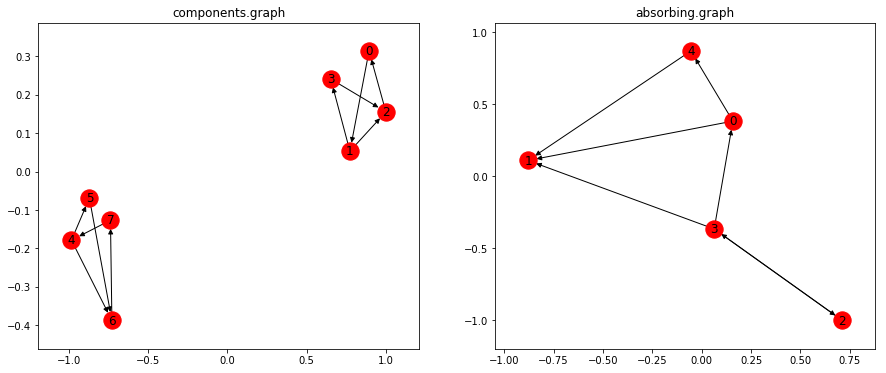

In [8]:
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
plt.title("components.graph")
nx.draw_networkx(components, arrows=True)

plt.subplot(1,2,2)
plt.title("absorbing.graph")
nx.draw_networkx(absorbing, arrows=True)

### Explanation
The components graph has two separate connected components. Therefore the random surfer will never leave the component that it randomly selected at the start.<br>
The absorbing graph has (as its name says) an absorbing node (node 1). Once the random surfer reaches this node, it will never leave it again.

#### Exercise 2.13

In [9]:
def random_walk_teleportation(G, iterations, teleportation_prob=.15):
    pages_count = np.zeros(G.number_of_nodes())
    n = np.random.choice(G.nodes())
    
    for i in range(iterations):
        pages_count[int(n)] += 1
        neighbours = list(G.neighbors(n))
        if len(neighbours) > 0 and np.random.rand(1) > teleportation_prob:
            n = np.random.choice(neighbours)
        else:
            n = np.random.choice(G.nodes())
        
    return pages_count / iterations

In [10]:
print_page_counts(random_walk_teleportation(components, iterations))

0 : 0.14122
1 : 0.13903
2 : 0.14412
3 : 0.07903
4 : 0.13686
5 : 0.07681
6 : 0.14299
7 : 0.13994


In the component with nodes 0 to 3, all nodes point to one other node, except for node 1 which points to node 2 and node 3. Therefore all surfers that visit node 1 will be splitted to two possible nodes. It could be expected that those two points will have lower rank. However, node 2 gets pointed to by more edges than the others. Therefore the big loser is node 3.<br>
Similarly in the second component.

In [11]:
print_page_counts(random_walk_teleportation(absorbing, iterations))

0 : 0.14774
1 : 0.33976
2 : 0.14864
3 : 0.2143
4 : 0.14956


Node 1 is the highest ranked. This makes sense, since it is pointed to by almost all other nodes.<br>
Node 3 comes second. While it has the same in-degree as most other nodes, it is the only one that 'inherits' all surfers from an other node (namely node 2 here).

---

### 2.4.2 Power Iteration Method

#### Exercise 2.14: Power Iteration method

In [3]:
wiki = nx.read_adjlist("../data/wikipedia.graph", create_using=nx.DiGraph())
titles= []
with open('../data/wikipedia_titles.tsv') as tsvfile:
    titles = list(csv.reader(tsvfile, delimiter='\t'))[1:]

In [4]:
def H(graph):
    H = np.zeros((graph.number_of_nodes(), graph.number_of_nodes()))
    edges = list(graph.edges)
    for u,v in edges:
        H[int(u)][int(v)] = 1 / len(list(graph.neighbors(u)))
    
    return H

In [5]:
def w(graph):
    nodes = list(graph.nodes)
    dangs = np.zeros(len(nodes))
    for n in nodes:
        if len(list(graph.neighbors(n))) == 0:
            dangs[int(n)] = 1
    return dangs

In [6]:
def G(graph, damping=.15):
    N = graph.number_of_nodes()
    H_caret = H(graph) + np.ones((N, N)) * w(graph)[..., np.newaxis] / N
    return (1-damping) * H_caret + damping * np.ones((N, N)) / N

In [25]:
def power_iterations(G, convergence=1e-4, iterations=100):
    N = G.shape[1]
    pi = np.ones(N) / N
    
    for i in range(iterations):
        pi_t = np.dot(pi, G)
        pi_t /= np.linalg.norm(pi_t)
        if np.linalg.norm(pi_t - pi) < convergence:
            print('Converged after', i, 'iterations')
            return pi_t
        pi = pi_t
    print('Reached max iterations')
    return pi

In [12]:
page_rank = power_iterations(G(wiki.copy()))

Converged after 59 iterations


In [13]:
ranks = np.argsort(page_rank)[::-1]
for i in range(10):
    index = ranks[i]
    print(i+1, ':', titles[index][1])

1 : United States
2 : United Kingdom
3 : France
4 : Europe
5 : Germany
6 : England
7 : World War II
8 : Latin
9 : India
10 : English language


---

### 2.4.3 Gaming the system

#### Exercise 2.15

In [14]:
def find_index_of_title(title):
    for t in titles:
        if t[1] == title:
            return int(t[0])
    return -1

In [29]:
hist_math_index = find_index_of_title('History of mathematics')
hist_math_rank = int(np.where(ranks==hist_math_index)[0])+1
print('node id:', hist_math_index, 'current ranking:', hist_math_rank)

node id: 2463 current ranking: 2530


We will iterate through the sorted page_rank list and add an edge from the most important pages to "History of mathematics" until 300 edges have been added (maybe there are already edges from the top 300 to "History of methematics", so we won't count those for our 300 added edges).

In [30]:
wiki_gamed = wiki.copy()
i = 0
e = len(list(wiki_gamed.in_edges('2463'))) + 300

# We are allowed to add 300 edges, so we keep adding from the best ranked sites until we got 300 new edges 
# (already existing don't count)
while len(list(wiki_gamed.in_edges('2463'))) < e:
    wiki_gamed.add_edge(str(ranks[i]), str(hist_math_index))
    i += 1

In [31]:
page_rank_gamed = power_iterations(G(wiki_gamed.copy()))

Converged after 15 iterations


In [32]:
ranks_gamed = np.argsort(page_rank_gamed)[::-1]
for i in range(5):
    index = ranks_gamed[i]
    print(i+1, ':', page_rank_gamed[index], titles[index][1])

1 : 0.2672438790529281 United States
2 : 0.18552654471794167 United Kingdom
3 : 0.1802607192149566 France
4 : 0.16946265130605132 History of mathematics
5 : 0.16054299768000707 Europe


We got from rank 2530 to rank 4. Pretty good, but let's try better.<br>

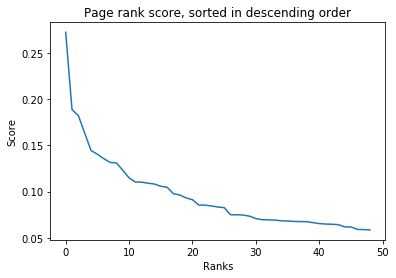

In [33]:
from matplotlib import pyplot
page_rank_sorted = sorted(page_rank)[:-50:-1]
plt.title('Page rank score, sorted in descending order')
plt.xlabel('Ranks')
plt.ylabel('Score')
plt.plot(page_rank_sorted)

Looking at the graph above, we see that it might not be the best idea to just add an edge from the top 300 pages to HoM, because the importance drops already drasticly after just a few ranks.<br>
Therefore we want to make more use of the truly important sites on places 1 to about 30 and forget about the rest.<br>
We do this by searching for dangling nodes in the graph, add an edge from them to "History of mathematics" and let the top 31 pages (number 31 found by brute force) point to each one of them. This not only creates extremely valuable endorsers for HoM, but also weakens the top pages because they get more outgoing edges.<br>
With 8 dangling nodes in the graph and 31 pages pointing to them, this gives a total of 8 + 8*31 = 256 added edges.<br>
So we can also add 44 direct edges from the top pages to HoM.<br>
This implementation got HoM to the second place. But of course we wouldn't quit that close to the summit.<br>
We know that HoM is currently on place 2530, but will be (preferably) on place 1. But it doesn't figure in our top ranked pages yet. So we preemtively add it such that it points to the new endorsers as well (and btw also to itself), and - voilà - HoM is the most important page on the internet.

In [34]:
wiki_gamed2 = wiki.copy()
danglings = w(wiki_gamed2)
gamed_ranks = ranks.copy()
gamed_ranks = np.insert(gamed_ranks, 0, 2463)

dangling_indices = []
for i in range(len(danglings)):
    if danglings[i] == 1:
        dangling_indices.append(str(i))

added = 0
for d in dangling_indices:
    if not wiki_gamed2.has_edge(d, '2463'):
        added += 1
        wiki_gamed2.add_edge(d, '2463')
    for n in gamed_ranks[:31]:
        if not wiki_gamed2.has_edge(str(n),d):
            added += 1
            wiki_gamed2.add_edge(str(n), d)
        
i = 0
while added < 300:
    if not wiki_gamed2.has_edge(str(gamed_ranks[i]), '2463'):
        wiki_gamed2.add_edge(str(gamed_ranks[i]), '2463')
        added += 1
    i += 1

In [35]:
page_rank_gamed2 = power_iterations(G(wiki_gamed2.copy()))

Converged after 16 iterations


In [36]:
ranks_gamed2 = np.argsort(page_rank_gamed2)[::-1]
for i in range(10):
    index = ranks_gamed2[i]
    print(i+1, ':', page_rank_gamed2[index], titles[index][1])

1 : 0.2601891984731936 History of mathematics
2 : 0.2591486351663234 United States
3 : 0.1802250148391046 United Kingdom
4 : 0.175083959758588 France
5 : 0.15619784046553017 Europe
6 : 0.1382423943219386 Germany
7 : 0.13578841921128215 England
8 : 0.12973837268960786 Latin
9 : 0.12926883572515982 World War II
10 : 0.12600612059698443 India


In [24]:
import operator

# Verify with networx implementation
pr = nx.pagerank(wiki_gamed2.copy())

sorted_pr = sorted(pr.items(), key=operator.itemgetter(1))
sorted_pr.reverse()
for i in range(10):
    index = int(sorted_pr[i][0])
    print(i+1, ':', titles[index][1])

1 : History of mathematics
2 : United States
3 : United Kingdom
4 : France
5 : Europe
6 : Germany
7 : England
8 : World War II
9 : Latin
10 : India
